In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from PIL import Image
import torch.nn.functional as F

In [3]:
# Unzip the dataset
zip_file_path = "/content/drive/MyDrive/DSCOVER/2학기 메인프로젝트/fdct_data_512.zip"
extract_dir = "dataset"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print('zip file extracted')

zip file extracted


In [4]:
# Define paths
data_dir = Path('/content/dataset/fdct_data_512')
train_dir = data_dir / 'train'
valid_dir = data_dir / 'valid'
test_dir = data_dir / 'test'

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Define transformations
# use mean, std of imagenet dataset to normalize( we will use model that is pretrained with imagenet dataset)
transform = {
    'train': transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [7]:
# Loading dataset and labeling
data = {
    'train': datasets.ImageFolder(train_dir, transform=transform['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=transform['valid']),
    'test': datasets.ImageFolder(test_dir, transform=transform['test'])
}

data_loader = {
    'train': DataLoader(data['train'], batch_size=16, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=16, shuffle=False),
    'test': DataLoader(data['test'], batch_size=16, shuffle=False)
}

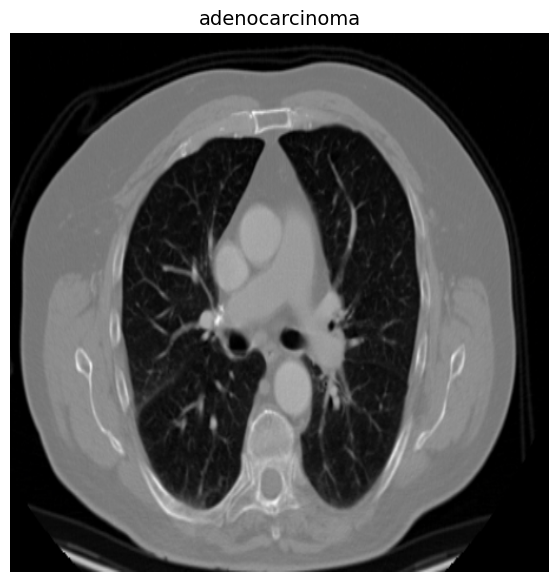

In [8]:
# Display an example image
def show_random_image(dataset, class_names, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    random_idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[random_idx]

    img_permute = img.permute(1, 2, 0)
    img = img_permute.numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_names[label], fontsize=14)
    plt.show()

# Show a random image from training set
show_random_image(data['train'], data['train'].classes, random_state=42)

In [9]:
class DilatedTransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate=2):
        super(DilatedTransitionLayer, self).__init__()
        self.dilated_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=dilation_rate,
            dilation=dilation_rate,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.dilated_conv(x)
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        return x

class ModifiedDenseNet121(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedDenseNet121, self).__init__()

        # Load the pre-defined DenseNet121
        from torchvision.models import densenet121
        original_densenet = densenet121(pretrained=True)

        # Extract layers from the original model
        self.features = original_densenet.features

        # Replace only the last Transition Layer
        self.features.transition3 = DilatedTransitionLayer(1024, 512, dilation_rate=4)

        # Final classification layer
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [10]:
# Load pre-trained DenseNet121 model
model = ModifiedDenseNet121(num_classes=4)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20):

    best_acc = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders['train'], desc=f"Train Epoch {epoch + 1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['valid'], desc=f"Validation Epoch {epoch + 1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(dataloaders['valid'].dataset)
        val_epoch_acc = val_running_corrects.double() / len(dataloaders['valid'].dataset)

        print(f"Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        # Save the best model weights
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict()

    print("Training complete")

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        torch.save(best_model_wts, "best_lung_cancer_Modified_densenet121.pth")
        print(f"Best model saved with accuracy: {best_acc:.4f}")

In [16]:
# Train the model
train_model(model, data_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------


Train Epoch 1: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Train Loss: 0.2941 Acc: 0.8907


Validation Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 0.4552 Acc: 0.8611
Epoch 2/20
----------


Train Epoch 2: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.2726 Acc: 0.9005


Validation Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Validation Loss: 1.2901 Acc: 0.6111
Epoch 3/20
----------


Train Epoch 3: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.1647 Acc: 0.9429


Validation Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Validation Loss: 0.4015 Acc: 0.8750
Epoch 4/20
----------


Train Epoch 4: 100%|██████████| 39/39 [00:11<00:00,  3.41it/s]


Train Loss: 0.1224 Acc: 0.9641


Validation Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Loss: 0.8073 Acc: 0.7361
Epoch 5/20
----------


Train Epoch 5: 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


Train Loss: 0.1936 Acc: 0.9250


Validation Epoch 5: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Loss: 0.5483 Acc: 0.8194
Epoch 6/20
----------


Train Epoch 6: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.2166 Acc: 0.9299


Validation Epoch 6: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.1415 Acc: 0.6806
Epoch 7/20
----------


Train Epoch 7: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.1282 Acc: 0.9576


Validation Epoch 7: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Validation Loss: 7.1538 Acc: 0.4583
Epoch 8/20
----------


Train Epoch 8: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.1636 Acc: 0.9445


Validation Epoch 8: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Validation Loss: 0.6807 Acc: 0.8056
Epoch 9/20
----------


Train Epoch 9: 100%|██████████| 39/39 [00:11<00:00,  3.42it/s]


Train Loss: 0.1545 Acc: 0.9543


Validation Epoch 9: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Validation Loss: 0.4348 Acc: 0.8889
Epoch 10/20
----------


Train Epoch 10: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.1003 Acc: 0.9674


Validation Epoch 10: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.3206 Acc: 0.6528
Epoch 11/20
----------


Train Epoch 11: 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


Train Loss: 0.1152 Acc: 0.9592


Validation Epoch 11: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Validation Loss: 1.6163 Acc: 0.7361
Epoch 12/20
----------


Train Epoch 12: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.0602 Acc: 0.9837


Validation Epoch 12: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Validation Loss: 0.4560 Acc: 0.8194
Epoch 13/20
----------


Train Epoch 13: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.0876 Acc: 0.9706


Validation Epoch 13: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Validation Loss: 0.4346 Acc: 0.8611
Epoch 14/20
----------


Train Epoch 14: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.0899 Acc: 0.9739


Validation Epoch 14: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Validation Loss: 0.6269 Acc: 0.8056
Epoch 15/20
----------


Train Epoch 15: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.0684 Acc: 0.9821


Validation Epoch 15: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Validation Loss: 0.7997 Acc: 0.8056
Epoch 16/20
----------


Train Epoch 16: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.0578 Acc: 0.9837


Validation Epoch 16: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 0.9047 Acc: 0.7778
Epoch 17/20
----------


Train Epoch 17: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.1415 Acc: 0.9527


Validation Epoch 17: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Validation Loss: 0.4685 Acc: 0.8472
Epoch 18/20
----------


Train Epoch 18: 100%|██████████| 39/39 [00:11<00:00,  3.41it/s]


Train Loss: 0.0496 Acc: 0.9837


Validation Epoch 18: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Validation Loss: 0.3059 Acc: 0.8889
Epoch 19/20
----------


Train Epoch 19: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.0887 Acc: 0.9674


Validation Epoch 19: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Validation Loss: 0.4610 Acc: 0.8750
Epoch 20/20
----------


Train Epoch 20: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.0917 Acc: 0.9706


Validation Epoch 20: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Validation Loss: 0.7487 Acc: 0.8889
Training complete
Best model saved with accuracy: 0.8889


In [17]:
# Test the model
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print()
    print(f"Test Accuracy: {accuracy:.4f}")

# Load the best model weights
def load_and_test_model(model_path, dataloader):
    model = ModifiedDenseNet121(num_classes=4)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    print("Testing with the best saved model...")
    test_model(model, dataloader)

In [18]:
best_model_path = '/content/best_lung_cancer_Modified_densenet121.pth'

In [19]:
# Evaluate on the test set using the best model
load_and_test_model(best_model_path, data_loader['test'])

<ipython-input-17-76bf64cc0eb0>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Testing with the best saved model...


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Test Accuracy: 0.5968
